In [8]:
import os

HOME = os.getcwd()
print(HOME)

/kaggle/working


## Install YOLO11 via Ultralytics

In [9]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6358.2/8062.4 GB disk)


In [10]:
%pip install optuna ray

Note: you may need to restart the kernel to use updated packages.


In [11]:
from ultralytics import YOLO

from IPython.display import display, Image
import optuna
from ultralytics import YOLO
# from ray.tune.integration.optuna import OptunaSearch
from ray import tune
from ray.tune.schedulers import ASHAScheduler
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob

## Dataset Loading

In [5]:
# Set up directory paths
# !mkdir {HOME}/datasets
# %cd {HOME}/datasets

/kaggle/working/datasets


In [6]:
# %ls ./runs/segment

train/     train1722/   train24/  train33/   train41/  train50/  train61/
train10/   train17222/  train25/  train34/   train42/  train51/  train62/
train11/   train18/     train26/  train35/   train43/  train52/  train622/
train12/   train182/    train27/  train36/   train44/  train54/  train7/
train13/   train19/     train28/  train37/   train45/  train55/  train8/
train14/   train2/      train29/  train38/   train46/  train57/  train9/
train15/   train20/     train3/   train39/   train47/  train58/
train16/   train21/     train30/  train392/  train48/  train59/
train17/   train22/     train31/  train4/    train49/  train6/
train172/  train23/     train32/  train40/   train5/   train60/


In [12]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="Sn1vSUk86V5QpQ25WfdA")
# project = rf.workspace("mohamed-traore-2ekkp").project("taco-trash-annotations-in-context")
# version = project.version(15)
# dataset = version.download("yolov11")
# https://universe.roboflow.com/taco-9911u/taco-trash-annotations-in-context-bumvw/dataset/5

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Sn1vSUk86V5QpQ25WfdA")
project = rf.workspace("taco-9911u").project("taco-trash-annotations-in-context-bumvw")
version = project.version(15)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


In [8]:
# !pip install roboflow

# from roboflow import Roboflow
# rf2 = Roboflow(api_key="Sn1vSUk86V5QpQ25WfdA")
# project2 = rf2.workspace("taco-9911u").project("taco-trash-annotations-in-context-nlbac")
# version2 = project2.version(8)
# dataset2 = version2.download("yolov11")

## Model Training

In [ ]:
# def search_by_extension(directory, extension):
#     """
#     Search for files with a specific extension in a directory.

#     Parameters:
#     directory (str): The directory to search.
#     extension (str): The file extension (e.g., ".txt").

#     Returns:
#     list: A list of paths to files with the given extension.
#     """
#     matches = []
#     for root, dirs, files in os.walk(directory):
#         for file in files:
#             if file.endswith(extension):
#                 matches.append(os.path.join(root, file))
#     return matches

# # Example usage
# results = search_by_extension("../..", ".pt")
# print("Python files found:", results)

In [ ]:
# %ls ../../input/taco_model/pytorch/default/1

In [13]:
# Define Dice Loss
class DiceLoss(torch.nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = preds.sigmoid()  # Convert logits to probabilities
        intersection = (preds * targets).sum()
        dice_coeff = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)
        return 1 - dice_coeff  # Dice loss is 1 - Dice coefficient

# Define Focal Loss with suggested gamma
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, preds, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(preds, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # Probability of correct classification
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss.mean()

# Define Hybrid Loss (Dice + Focal)
class DiceFocalLoss(torch.nn.Module):
    def __init__(self):
        super(DiceFocalLoss, self).__init__()
        self.dice = DiceLoss()
        self.focal = FocalLoss(gamma=1.6)

    def forward(self, preds, targets):
        return self.dice(preds, targets) + self.focal(preds, targets)

In [14]:
%ls ..

input/  lib/  working/


In [7]:
# # model = YOLO("../../input/taco_last_models/pytorch/default/1/train_41_last.pt")
# # model = YOLO('../best_v10_64.pt')
# # model = YOLO("runs/segment/train43/weights/last.pt")
# # Set the data path

# data_path = f'{dataset.location}/data.yaml'  # Replace with actual path

# # Apply custom loss
# model.loss = DiceFocalLoss()

In [17]:
# Define the objective function
def objective(trial):
    
    model = YOLO("../../input/taco_last_models/pytorch/default/1/train_41_last.pt")
    data_path = f'{dataset.location}/data.yaml'  # Replace with actual path

    # Apply custom loss
    model.loss = DiceFocalLoss()
    
    # Suggest hyperparameters
    lr0 = trial.suggest_float("lr0", .00012, .00015,step=.00001)  
    dropout = trial.suggest_float("dropout", 0.36, 0.4, step=0.02)  
    weight_decay = trial.suggest_float("weight_decay", 1e-4, 5e-4, step=1e-4)

    # Train the model with suggested hyperparameters
    results = model.train(
        data=data_path,
        epochs=15,
        imgsz=736,
        batch=8,  
        lr0=lr0,    
        plots=True,
        patience=5,
        dropout=dropout,  
        weight_decay=weight_decay,  
        cos_lr=True,    
        warmup_epochs=3,
        optimizer = "SGD",
        optimize = True,
        augment = True,
        save_dir="runs/segment/taco_train"
    )

In [18]:
# Optuna optimization set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

[I 2025-05-30 11:44:22,344] A new study created in memory with name: no-name-290f2c88-7e76-48b8-be6b-8bacb3512c22


New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=../input/taco_last_models/pytorch/default/1/train_41_last.pt, data=/kaggle/working/TACO:-Trash-Annotations-in-Context-Dataset-15/data.yaml, epochs=15, time=None, patience=5, batch=8, imgsz=736, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train16, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.38, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False

train: Scanning /kaggle/working/TACO:-Trash-Annotations-in-Context-Dataset-15/train/labels.cache... 3055 images, 1 backgrounds, 0 corrupt: 100%|██████████| 3055/3055 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /kaggle/working/TACO:-Trash-Annotations-in-Context-Dataset-15/valid/labels.cache... 110 images, 0 backgrounds, 0 corrupt: 100%|██████████| 110/110 [00:00<?, ?it/s]


Plotting labels to runs/segment/train16/labels.jpg... 
optimizer: SGD(lr=0.00013000000000000002, momentum=0.937) with parameter groups 176 weight(decay=0.0), 187 weight(decay=0.0001), 186 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 736 train, 736 val
Using 4 dataloader workers
Logging results to runs/segment/train16
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/15      16.5G     0.6829      1.032     0.6069     0.9997         12        736: 100%|██████████| 382/382 [09:11<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

                   all        110        164      0.527       0.57      0.603      0.542      0.523      0.565      0.592      0.525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/15      16.3G     0.6769       1.04     0.6006      1.002         17        736: 100%|██████████| 382/382 [09:04<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

                   all        110        164      0.689      0.527      0.609      0.556      0.683      0.522      0.601       0.53



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/15      16.3G     0.6549      1.038     0.5762     0.9887         12        736: 100%|██████████| 382/382 [09:03<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

                   all        110        164      0.785        0.5      0.619      0.559      0.786      0.492      0.609       0.54



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/15      16.4G      0.673      1.015     0.5814     0.9997         13        736: 100%|██████████| 382/382 [09:02<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

                   all        110        164       0.65       0.54      0.607      0.545      0.644      0.536      0.597      0.529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/15      16.3G     0.6466     0.9919     0.5533     0.9853         12        736: 100%|██████████| 382/382 [09:02<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

                   all        110        164      0.629       0.54      0.595      0.538      0.629       0.54      0.591       0.52


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/15      16.3G      0.563     0.9893     0.4466     0.8993         16        736: 100%|██████████| 382/382 [09:02<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        110        164      0.517      0.608      0.567       0.51      0.503       0.59      0.553      0.492



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/15      16.1G      0.553     0.9692     0.4296      0.899         11        736: 100%|██████████| 382/382 [09:01<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

                   all        110        164      0.739      0.526      0.575      0.519      0.735       0.49      0.553      0.488



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/15      16.3G     0.5503     0.9622      0.422     0.8975          9        736: 100%|██████████| 382/382 [09:01<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]

                   all        110        164      0.707      0.537      0.602      0.547      0.723      0.517      0.584       0.52
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 3, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



8 epochs completed in 1.230 hours.
Optimizer stripped from runs/segment/train16/weights/last.pt, 124.8MB
Optimizer stripped from runs/segment/train16/weights/best.pt, 124.8MB

Validating runs/segment/train16/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11x-seg summary (fused): 491 layers, 62,026,383 parameters, 0 gradients, 318.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


                   all        110        164      0.785        0.5      0.619       0.56      0.786      0.492       0.61      0.541
  Clear plastic bottle         22         29       0.94      0.724      0.856      0.755      0.945      0.724      0.856      0.698
     Corrugated carton          5          7       0.61      0.286      0.456      0.421      0.621      0.286      0.341      0.318
          Crisp packet          4          4      0.413       0.25       0.37       0.37      0.428       0.25       0.37       0.37
Disposable food container          4          4          1          0     0.0209     0.0209          1          0     0.0209     0.0209
Disposable plastic cup         11         12      0.485      0.333      0.318      0.289       0.49      0.333      0.318      0.202
            Egg carton          2          2      0.813        0.5      0.508      0.508      0.838        0.5      0.508      0.508
              Foam cup          2          2      0.744        0.5

[W 2025-05-30 12:58:38,410] Trial 0 failed with parameters: {'lr0': 0.00013000000000000002, 'dropout': 0.38, 'weight_decay': 0.0001} because of the following error: The value None could not be cast to float..
[W 2025-05-30 12:58:38,412] Trial 0 failed with value None.


New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=../input/taco_last_models/pytorch/default/1/train_41_last.pt, data=/kaggle/working/TACO:-Trash-Annotations-in-Context-Dataset-15/data.yaml, epochs=15, time=None, patience=5, batch=8, imgsz=736, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train17, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.39999999999999997, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, 

train: Scanning /kaggle/working/TACO:-Trash-Annotations-in-Context-Dataset-15/train/labels.cache... 3055 images, 1 backgrounds, 0 corrupt: 100%|██████████| 3055/3055 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /kaggle/working/TACO:-Trash-Annotations-in-Context-Dataset-15/valid/labels.cache... 110 images, 0 backgrounds, 0 corrupt: 100%|██████████| 110/110 [00:00<?, ?it/s]


Plotting labels to runs/segment/train17/labels.jpg... 
optimizer: SGD(lr=0.00013000000000000002, momentum=0.937) with parameter groups 176 weight(decay=0.0), 187 weight(decay=0.0005), 186 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 736 train, 736 val
Using 4 dataloader workers
Logging results to runs/segment/train17
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/15      16.6G     0.6828      1.033     0.6072     0.9998         12        736: 100%|██████████| 382/382 [09:11<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]

                   all        110        164      0.526      0.571      0.603      0.541      0.521      0.566      0.592      0.524



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/15      16.4G      0.677       1.04      0.601      1.002         17        736: 100%|██████████| 382/382 [09:04<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]

                   all        110        164      0.708      0.518      0.613      0.555      0.702      0.513      0.604       0.53



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/15      16.4G     0.6548      1.038     0.5761     0.9885         12        736: 100%|██████████| 382/382 [09:03<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]

                   all        110        164      0.762      0.512      0.615      0.553      0.755      0.506      0.605      0.535



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/15      16.3G     0.6738      1.014     0.5817          1         13        736: 100%|██████████| 382/382 [09:02<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]

                   all        110        164      0.682      0.506        0.6      0.539      0.682      0.506      0.589      0.521



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/15      16.4G     0.6476     0.9935      0.555     0.9868         12        736: 100%|██████████| 382/382 [09:02<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]

                   all        110        164       0.69      0.505      0.594      0.539      0.683        0.5      0.588      0.525


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/15      16.3G     0.5637     0.9897      0.448     0.9003         16        736: 100%|██████████| 382/382 [09:02<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        110        164       0.76      0.491       0.58      0.525      0.754      0.487      0.563      0.496



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/15        16G     0.5521     0.9691     0.4289     0.9005         11        736: 100%|██████████| 382/382 [09:02<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]

                   all        110        164      0.641      0.571      0.582      0.526      0.613      0.552      0.559      0.492



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/15      16.3G     0.5493     0.9608     0.4215     0.8976          9        736: 100%|██████████| 382/382 [09:03<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        110        164      0.679       0.55       0.58      0.528      0.661      0.537      0.561      0.499
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 3, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



8 epochs completed in 1.237 hours.
Optimizer stripped from runs/segment/train17/weights/last.pt, 124.8MB
Optimizer stripped from runs/segment/train17/weights/best.pt, 124.8MB

Validating runs/segment/train17/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11x-seg summary (fused): 491 layers, 62,026,383 parameters, 0 gradients, 318.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]


                   all        110        164      0.745      0.513      0.614      0.553      0.792      0.487      0.605      0.534
  Clear plastic bottle         22         29      0.866      0.724      0.866      0.754      0.934      0.724      0.866      0.707
     Corrugated carton          5          7      0.561      0.286        0.5      0.457      0.639      0.286      0.383      0.361
          Crisp packet          4          4      0.335       0.25       0.37       0.36      0.462       0.25       0.37       0.37
Disposable food container          4          4          1          0     0.0232     0.0232          1          0     0.0232     0.0232
Disposable plastic cup         11         12      0.452      0.333      0.329      0.288      0.491      0.333      0.329      0.193
            Egg carton          2          2      0.721        0.5      0.506      0.506      0.886        0.5      0.506      0.506
              Foam cup          2          2       0.68        0.5

[W 2025-05-30 14:13:19,274] Trial 1 failed with parameters: {'lr0': 0.00013000000000000002, 'dropout': 0.39999999999999997, 'weight_decay': 0.0005} because of the following error: The value None could not be cast to float..
[W 2025-05-30 14:13:19,276] Trial 1 failed with value None.


New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=../input/taco_last_models/pytorch/default/1/train_41_last.pt, data=/kaggle/working/TACO:-Trash-Annotations-in-Context-Dataset-15/data.yaml, epochs=15, time=None, patience=5, batch=8, imgsz=736, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train18, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.38, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False

train: Scanning /kaggle/working/TACO:-Trash-Annotations-in-Context-Dataset-15/train/labels.cache... 3055 images, 1 backgrounds, 0 corrupt: 100%|██████████| 3055/3055 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /kaggle/working/TACO:-Trash-Annotations-in-Context-Dataset-15/valid/labels.cache... 110 images, 0 backgrounds, 0 corrupt: 100%|██████████| 110/110 [00:00<?, ?it/s]


Plotting labels to runs/segment/train18/labels.jpg... 
optimizer: SGD(lr=0.00014000000000000001, momentum=0.937) with parameter groups 176 weight(decay=0.0), 187 weight(decay=0.0005), 186 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 736 train, 736 val
Using 4 dataloader workers
Logging results to runs/segment/train18
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/15      16.5G     0.6828      1.032     0.6068     0.9999         12        736: 100%|██████████| 382/382 [09:14<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.04it/s]

                   all        110        164      0.524      0.571      0.605      0.544      0.519      0.565      0.594      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/15      16.4G     0.6767       1.04     0.6008      1.001         17        736: 100%|██████████| 382/382 [09:07<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        110        164      0.665      0.533      0.616      0.564      0.659      0.528      0.607       0.54



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/15      16.4G     0.6549      1.038     0.5761     0.9885         12        736: 100%|██████████| 382/382 [09:05<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        110        164      0.786      0.488      0.602      0.543      0.786      0.488      0.594      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/15      16.4G     0.6732      1.014     0.5812     0.9988         13        736: 100%|██████████| 382/382 [09:05<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        110        164       0.65      0.529      0.596      0.535      0.743      0.501      0.586      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/15      16.4G     0.6486     0.9937     0.5568     0.9861         12        736: 100%|██████████| 382/382 [09:05<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        110        164      0.724      0.523      0.587      0.532      0.758      0.503       0.58      0.516


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/15      16.3G     0.5624     0.9888     0.4476     0.8983         16        736: 100%|██████████| 382/382 [09:05<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.03it/s]

                   all        110        164      0.539      0.612      0.579      0.523      0.752       0.49      0.558      0.495



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/15        16G      0.552     0.9689     0.4296     0.8994         11        736: 100%|██████████| 382/382 [09:04<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        110        164      0.769      0.514      0.581       0.52       0.75      0.497      0.558      0.494
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 2, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



7 epochs completed in 1.090 hours.
Optimizer stripped from runs/segment/train18/weights/last.pt, 124.8MB
Optimizer stripped from runs/segment/train18/weights/best.pt, 124.8MB

Validating runs/segment/train18/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11x-seg summary (fused): 491 layers, 62,026,383 parameters, 0 gradients, 318.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]


                   all        110        164      0.665       0.53      0.617      0.566      0.658      0.526      0.608      0.541
  Clear plastic bottle         22         29      0.798      0.724      0.852      0.736      0.798      0.724      0.852      0.686
     Corrugated carton          5          7       0.54      0.286      0.521      0.499       0.54      0.286      0.393      0.377
          Crisp packet          4          4      0.359      0.432      0.399      0.396      0.359      0.432      0.399      0.393
Disposable food container          4          4          0          0      0.022      0.022          0          0      0.022      0.022
Disposable plastic cup         11         12      0.427      0.333      0.366      0.329      0.427      0.333      0.366      0.207
            Egg carton          2          2      0.913        0.5      0.506      0.506      0.913        0.5      0.506      0.506
              Foam cup          2          2      0.646        0.5

[W 2025-05-30 15:19:11,533] Trial 2 failed with parameters: {'lr0': 0.00014000000000000001, 'dropout': 0.38, 'weight_decay': 0.0005} because of the following error: The value None could not be cast to float..
[W 2025-05-30 15:19:11,534] Trial 2 failed with value None.


New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=../input/taco_last_models/pytorch/default/1/train_41_last.pt, data=/kaggle/working/TACO:-Trash-Annotations-in-Context-Dataset-15/data.yaml, epochs=15, time=None, patience=5, batch=8, imgsz=736, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train19, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.36, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False

train: Scanning /kaggle/working/TACO:-Trash-Annotations-in-Context-Dataset-15/train/labels.cache... 3055 images, 1 backgrounds, 0 corrupt: 100%|██████████| 3055/3055 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /kaggle/working/TACO:-Trash-Annotations-in-Context-Dataset-15/valid/labels.cache... 110 images, 0 backgrounds, 0 corrupt: 100%|██████████| 110/110 [00:00<?, ?it/s]


Plotting labels to runs/segment/train19/labels.jpg... 
optimizer: SGD(lr=0.00015, momentum=0.937) with parameter groups 176 weight(decay=0.0), 187 weight(decay=0.00030000000000000003), 186 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 736 train, 736 val
Using 4 dataloader workers
Logging results to runs/segment/train19
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/15      16.5G     0.6827      1.032      0.607     0.9997         12        736: 100%|██████████| 382/382 [09:14<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        110        164      0.525      0.571      0.606      0.543       0.52      0.567      0.595      0.524



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/15      16.4G     0.6764      1.038     0.5999      1.001         17        736: 100%|██████████| 382/382 [09:07<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        110        164      0.682      0.531      0.611      0.553      0.676      0.526      0.602      0.531



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/15      16.4G     0.6542      1.038     0.5764     0.9882         12        736: 100%|██████████| 382/382 [09:05<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        110        164       0.79      0.499      0.616      0.554       0.79      0.499       0.61      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/15      16.3G      0.673      1.013     0.5815     0.9996         13        736: 100%|██████████| 382/382 [09:05<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        110        164      0.626      0.529      0.577      0.519      0.626      0.529      0.569      0.501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/15      16.4G     0.6469     0.9924     0.5592     0.9859         12        736: 100%|██████████| 382/382 [09:05<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        110        164      0.727      0.503      0.591      0.538      0.724      0.501      0.584      0.519


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/15      16.3G     0.5612     0.9861     0.4446     0.8972         16        736: 100%|██████████| 382/382 [09:05<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.03it/s]

                   all        110        164      0.549      0.593      0.581      0.527      0.524      0.573      0.563      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/15      16.1G     0.5517      0.967     0.4276     0.8981         11        736: 100%|██████████| 382/382 [09:04<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        110        164      0.645       0.56      0.585      0.526      0.624      0.542      0.565      0.503



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/15      16.4G     0.5486     0.9585     0.4197     0.8969          9        736: 100%|██████████| 382/382 [09:04<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        110        164      0.713      0.515      0.575      0.523      0.712      0.498      0.556      0.495
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 3, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



8 epochs completed in 1.243 hours.
Optimizer stripped from runs/segment/train19/weights/last.pt, 124.8MB
Optimizer stripped from runs/segment/train19/weights/best.pt, 124.8MB

Validating runs/segment/train19/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11x-seg summary (fused): 491 layers, 62,026,383 parameters, 0 gradients, 318.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


                   all        110        164       0.79      0.499      0.616      0.554       0.79      0.499       0.61      0.536
  Clear plastic bottle         22         29      0.945      0.724      0.861      0.759      0.945      0.724      0.861      0.698
     Corrugated carton          5          7      0.621      0.286      0.504       0.46      0.621      0.286      0.391      0.367
          Crisp packet          4          4      0.357       0.25      0.368      0.358      0.357       0.25      0.368      0.368
Disposable food container          4          4          1          0       0.02       0.02          1          0       0.02       0.02
Disposable plastic cup         11         12      0.493      0.333       0.35      0.309      0.493      0.333       0.35      0.194
            Egg carton          2          2      0.795        0.5      0.506      0.506      0.795        0.5      0.506      0.506
              Foam cup          2          2      0.754        0.5

[W 2025-05-30 16:34:16,573] Trial 3 failed with parameters: {'lr0': 0.00015, 'dropout': 0.36, 'weight_decay': 0.00030000000000000003} because of the following error: The value None could not be cast to float..
[W 2025-05-30 16:34:16,575] Trial 3 failed with value None.


New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=../input/taco_last_models/pytorch/default/1/train_41_last.pt, data=/kaggle/working/TACO:-Trash-Annotations-in-Context-Dataset-15/data.yaml, epochs=15, time=None, patience=5, batch=8, imgsz=736, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train20, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.38, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False

train: Scanning /kaggle/working/TACO:-Trash-Annotations-in-Context-Dataset-15/train/labels.cache... 3055 images, 1 backgrounds, 0 corrupt: 100%|██████████| 3055/3055 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /kaggle/working/TACO:-Trash-Annotations-in-Context-Dataset-15/valid/labels.cache... 110 images, 0 backgrounds, 0 corrupt: 100%|██████████| 110/110 [00:00<?, ?it/s]


Plotting labels to runs/segment/train20/labels.jpg... 
optimizer: SGD(lr=0.00015, momentum=0.937) with parameter groups 176 weight(decay=0.0), 187 weight(decay=0.00030000000000000003), 186 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 736 train, 736 val
Using 4 dataloader workers
Logging results to runs/segment/train20
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/15      16.6G     0.6827      1.032      0.607     0.9997         12        736: 100%|██████████| 382/382 [09:13<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        110        164      0.525      0.571      0.606      0.543       0.52      0.567      0.595      0.524



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/15      16.4G     0.6764      1.038     0.5999      1.001         17        736: 100%|██████████| 382/382 [09:07<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.04it/s]

                   all        110        164      0.682      0.531      0.611      0.553      0.676      0.526      0.602      0.531



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/15      16.4G     0.6542      1.038     0.5764     0.9882         12        736: 100%|██████████| 382/382 [09:04<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]

                   all        110        164       0.79      0.499      0.616      0.554       0.79      0.499       0.61      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/15      16.4G      0.673      1.013     0.5815     0.9996         13        736: 100%|██████████| 382/382 [09:03<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]

                   all        110        164      0.626      0.529      0.577      0.519      0.626      0.529      0.569      0.501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/15      16.4G     0.6469     0.9924     0.5592     0.9859         12        736: 100%|██████████| 382/382 [09:03<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        110        164      0.727      0.503      0.591      0.538      0.724      0.501      0.584      0.519


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/15      16.3G     0.5612     0.9861     0.4446     0.8972         16        736: 100%|██████████| 382/382 [09:03<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.04it/s]

                   all        110        164      0.549      0.593      0.581      0.527      0.524      0.573      0.563      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/15      16.1G     0.5517      0.967     0.4276     0.8981         11        736: 100%|██████████| 382/382 [09:02<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]

                   all        110        164      0.645       0.56      0.585      0.526      0.624      0.542      0.565      0.503



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/15      16.4G     0.5486     0.9585     0.4197     0.8969          9        736: 100%|██████████| 382/382 [09:02<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]

                   all        110        164      0.713      0.515      0.575      0.523      0.712      0.498      0.556      0.495
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 3, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



8 epochs completed in 1.240 hours.
Optimizer stripped from runs/segment/train20/weights/last.pt, 124.8MB
Optimizer stripped from runs/segment/train20/weights/best.pt, 124.8MB

Validating runs/segment/train20/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11x-seg summary (fused): 491 layers, 62,026,383 parameters, 0 gradients, 318.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


                   all        110        164       0.79      0.499      0.616      0.554       0.79      0.499       0.61      0.536
  Clear plastic bottle         22         29      0.945      0.724      0.861      0.759      0.945      0.724      0.861      0.698
     Corrugated carton          5          7      0.621      0.286      0.504       0.46      0.621      0.286      0.391      0.367
          Crisp packet          4          4      0.357       0.25      0.368      0.358      0.357       0.25      0.368      0.368
Disposable food container          4          4          1          0       0.02       0.02          1          0       0.02       0.02
Disposable plastic cup         11         12      0.493      0.333       0.35      0.309      0.493      0.333       0.35      0.194
            Egg carton          2          2      0.795        0.5      0.506      0.506      0.795        0.5      0.506      0.506
              Foam cup          2          2      0.754        0.5

[W 2025-05-30 17:49:08,595] Trial 4 failed with parameters: {'lr0': 0.00015, 'dropout': 0.38, 'weight_decay': 0.00030000000000000003} because of the following error: The value None could not be cast to float..
[W 2025-05-30 17:49:08,596] Trial 4 failed with value None.


In [40]:
ls

runs/
TACO:-Trash-Annotations-in-Context-Dataset-11/
TACO:-Trash-Annotations-in-Context-Dataset-12/
TACO:-Trash-Annotations-in-Context-Dataset-14/
TACO:-Trash-Annotations-in-Context-Dataset-15/
yolo11n.pt
yolo11x-seg.pt


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


In [49]:
model = YOLO("../best_v10_64.pt")
data_path = f'{dataset.location}/data.yaml'  # Replace with actual path
model.loss = DiceFocalLoss()

model.train(
        data=data_path,
        epochs=50,
        imgsz=736,
        batch=8,  
        lr0=0.00012,    
        plots=True,
        patience=15,
        dropout=0.4,  
        optimizer='SGD',
        weight_decay=3e-4,  
        cos_lr=True, 
        optimize=True,
        augment=True
    )

New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=../best_v10_64.pt, data=/kaggle/working/datasets/TACO:-Trash-Annotations-in-Context-Dataset-15/data.yaml, epochs=50, time=None, patience=15, batch=8, imgsz=736, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train48, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.4, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False

train: Scanning /kaggle/working/datasets/TACO:-Trash-Annotations-in-Context-Dataset-15/train/labels.cache... 3055 images, 1 backgrounds, 0 corrupt: 100%|██████████| 3055/3055 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /kaggle/working/datasets/TACO:-Trash-Annotations-in-Context-Dataset-15/valid/labels.cache... 110 images, 0 backgrounds, 0 corrupt: 100%|██████████| 110/110 [00:00<?, ?it/s]


Plotting labels to runs/segment/train48/labels.jpg... 
optimizer: SGD(lr=0.00012, momentum=0.937) with parameter groups 176 weight(decay=0.0), 187 weight(decay=0.0003), 186 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 736 train, 736 val
Using 4 dataloader workers
Logging results to runs/segment/train48
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      15.6G     0.6636      1.015     0.5557     0.9872         12        736: 100%|██████████| 382/382 [09:12<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]

                   all        110        164      0.562      0.639      0.641      0.577      0.559      0.631      0.623      0.551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      15.6G     0.6622       1.02     0.5557     0.9919         17        736: 100%|██████████| 382/382 [09:06<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        110        164      0.585      0.612      0.633       0.57      0.578      0.603      0.617      0.546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50      15.5G     0.6449      1.018     0.5415     0.9833         12        736: 100%|██████████| 382/382 [09:05<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]

                   all        110        164      0.572      0.605       0.63       0.57      0.565      0.598      0.622      0.554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50      15.5G     0.6646      1.001     0.5538     0.9927         13        736: 100%|██████████| 382/382 [09:04<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]

                   all        110        164      0.592      0.595       0.64      0.576      0.574       0.58      0.627      0.551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50      15.5G     0.6382     0.9813     0.5313     0.9799         12        736: 100%|██████████| 382/382 [09:04<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        110        164      0.559      0.642      0.637      0.571      0.549      0.633      0.619       0.55



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      15.5G     0.6374     0.9646     0.5303     0.9742         27        736: 100%|██████████| 382/382 [09:04<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        110        164      0.728      0.556       0.63      0.566      0.723      0.552      0.613      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50      15.3G     0.6446     0.9402     0.5267     0.9799         36        736: 100%|██████████| 382/382 [09:04<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]

                   all        110        164      0.626      0.585      0.621       0.56      0.611      0.566      0.604      0.543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50      15.5G     0.6478     0.9513     0.5315     0.9778         25        736: 100%|██████████| 382/382 [09:04<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]

                   all        110        164      0.606      0.571      0.606       0.55      0.598       0.56      0.591      0.525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50      15.5G     0.6398     0.9622     0.5315     0.9704         23        736: 100%|██████████| 382/382 [09:04<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        110        164      0.749      0.495      0.618      0.564      0.767      0.479      0.601      0.537



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50      15.5G     0.6345     0.9478     0.5281     0.9772         11        736: 100%|██████████| 382/382 [09:04<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        110        164      0.642      0.531        0.6      0.545      0.775       0.44      0.587      0.521



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      15.4G     0.6255     0.9362     0.5119      0.965         18        736: 100%|██████████| 382/382 [09:04<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

                   all        110        164      0.718      0.504      0.592      0.539      0.706      0.494      0.579      0.513



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      15.5G     0.6184      0.917     0.5044     0.9676         17        736: 100%|██████████| 382/382 [09:02<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

                   all        110        164      0.741      0.478      0.605      0.551       0.73      0.468      0.589      0.524



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50      15.6G     0.6298     0.9349      0.511     0.9707         21        736: 100%|██████████| 382/382 [09:02<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]

                   all        110        164      0.543      0.548      0.605      0.551        0.8      0.459      0.596      0.525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50      15.5G     0.6188     0.9172     0.4965     0.9656         14        736: 100%|██████████| 382/382 [09:02<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        110        164      0.545       0.58      0.619      0.561      0.586      0.572      0.608      0.537



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50      15.3G     0.6252     0.9181     0.5126     0.9633         17        736: 100%|██████████| 382/382 [09:04<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

                   all        110        164      0.733        0.5      0.594      0.538      0.733      0.498      0.584      0.511



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50      15.6G      0.608      0.898     0.4906     0.9588         19        736: 100%|██████████| 382/382 [09:04<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]

                   all        110        164       0.74       0.52       0.61       0.56      0.729      0.513        0.6      0.532
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



16 epochs completed in 2.459 hours.
Optimizer stripped from runs/segment/train48/weights/last.pt, 124.8MB
Optimizer stripped from runs/segment/train48/weights/best.pt, 124.8MB

Validating runs/segment/train48/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11x-seg summary (fused): 491 layers, 62,026,383 parameters, 0 gradients, 318.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/7 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  14%|█▍        | 1/7 [00:00<00:05,  1.11it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▊       | 2/7 [00:02<00:05,  1.06s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  43%|████▎     | 3/7 [00:03<00:04,  1.09s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  57%|█████▋    | 4/7 [00:04<00:03,  1.09s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████▏  | 5/7 [00:05<00:02,  1.02s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  86%|████████▌ | 6/7 [00:06<00:00,  1.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


                   all        110        164      0.563      0.639      0.641      0.578       0.56      0.631      0.624      0.552
  Clear plastic bottle         22         29      0.788      0.759      0.867      0.762      0.789      0.759      0.867        0.7
     Corrugated carton          5          7      0.476      0.571      0.573      0.541      0.239      0.286      0.372      0.357
          Crisp packet          4          4      0.374      0.457      0.428      0.406      0.372      0.453      0.428      0.411
Disposable food container          4          4          0          0          0          0          0          0          0          0
Disposable plastic cup         11         12      0.381        0.5      0.295      0.268      0.382        0.5      0.295      0.182
            Egg carton          2          2      0.566        0.5      0.515      0.515      0.568        0.5      0.515      0.515
              Foam cup          2          2      0.539        0.5

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78c0e43ed870>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.03503

In [7]:
!cd {HOME}

# Define YOLO training parameters and execute it
#!yolo task=segment mode=train model=yolov8x-seg.pt data={dataset.location}/data.yaml epochs=105 imgsz=544 dropout=0.2 optimizer=SGD patience=50
# !yolo task=segment mode=train model=yolo11x-seg.pt data={dataset.location}/data.yaml epochs=300 imgsz=544 lr0=0.001 dropout=0.3 plots=True patience=50 optimizer=SGD
!yolo task=segment mode=train model=best_v10_64.pt data={dataset.location}/data.yaml epochs=2 imgsz=736 lr0=0.00012 dropout=0.4 plots=True optimizer=SGD batch=8
# !yolo task=segment mode=train model={model} data={dataset.location}/data.yaml epochs=300 imgsz=544 lr0=0.001 dropout=0.1 plots=True patience=50 optimizer=SGD

New https://pypi.org/project/ultralytics/8.3.102 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=segment, mode=train, model=best_v10_64.pt, data=/kaggle/working/TACO:-Trash-Annotations-in-Context-Dataset-15/data.yaml, epochs=2, time=None, patience=100, batch=8, imgsz=736, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.4, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

### List files in the specified directory


In [ ]:
!ls {HOME}/runs/segment

# Model Evaluation
## Confusion Matrix

In [ ]:
%ls ../lib/kaggle

In [ ]:
%ls . 


In [ ]:
%ls ./runs/segment

In [ ]:
 %ls ./runs/segment

/kaggle/working


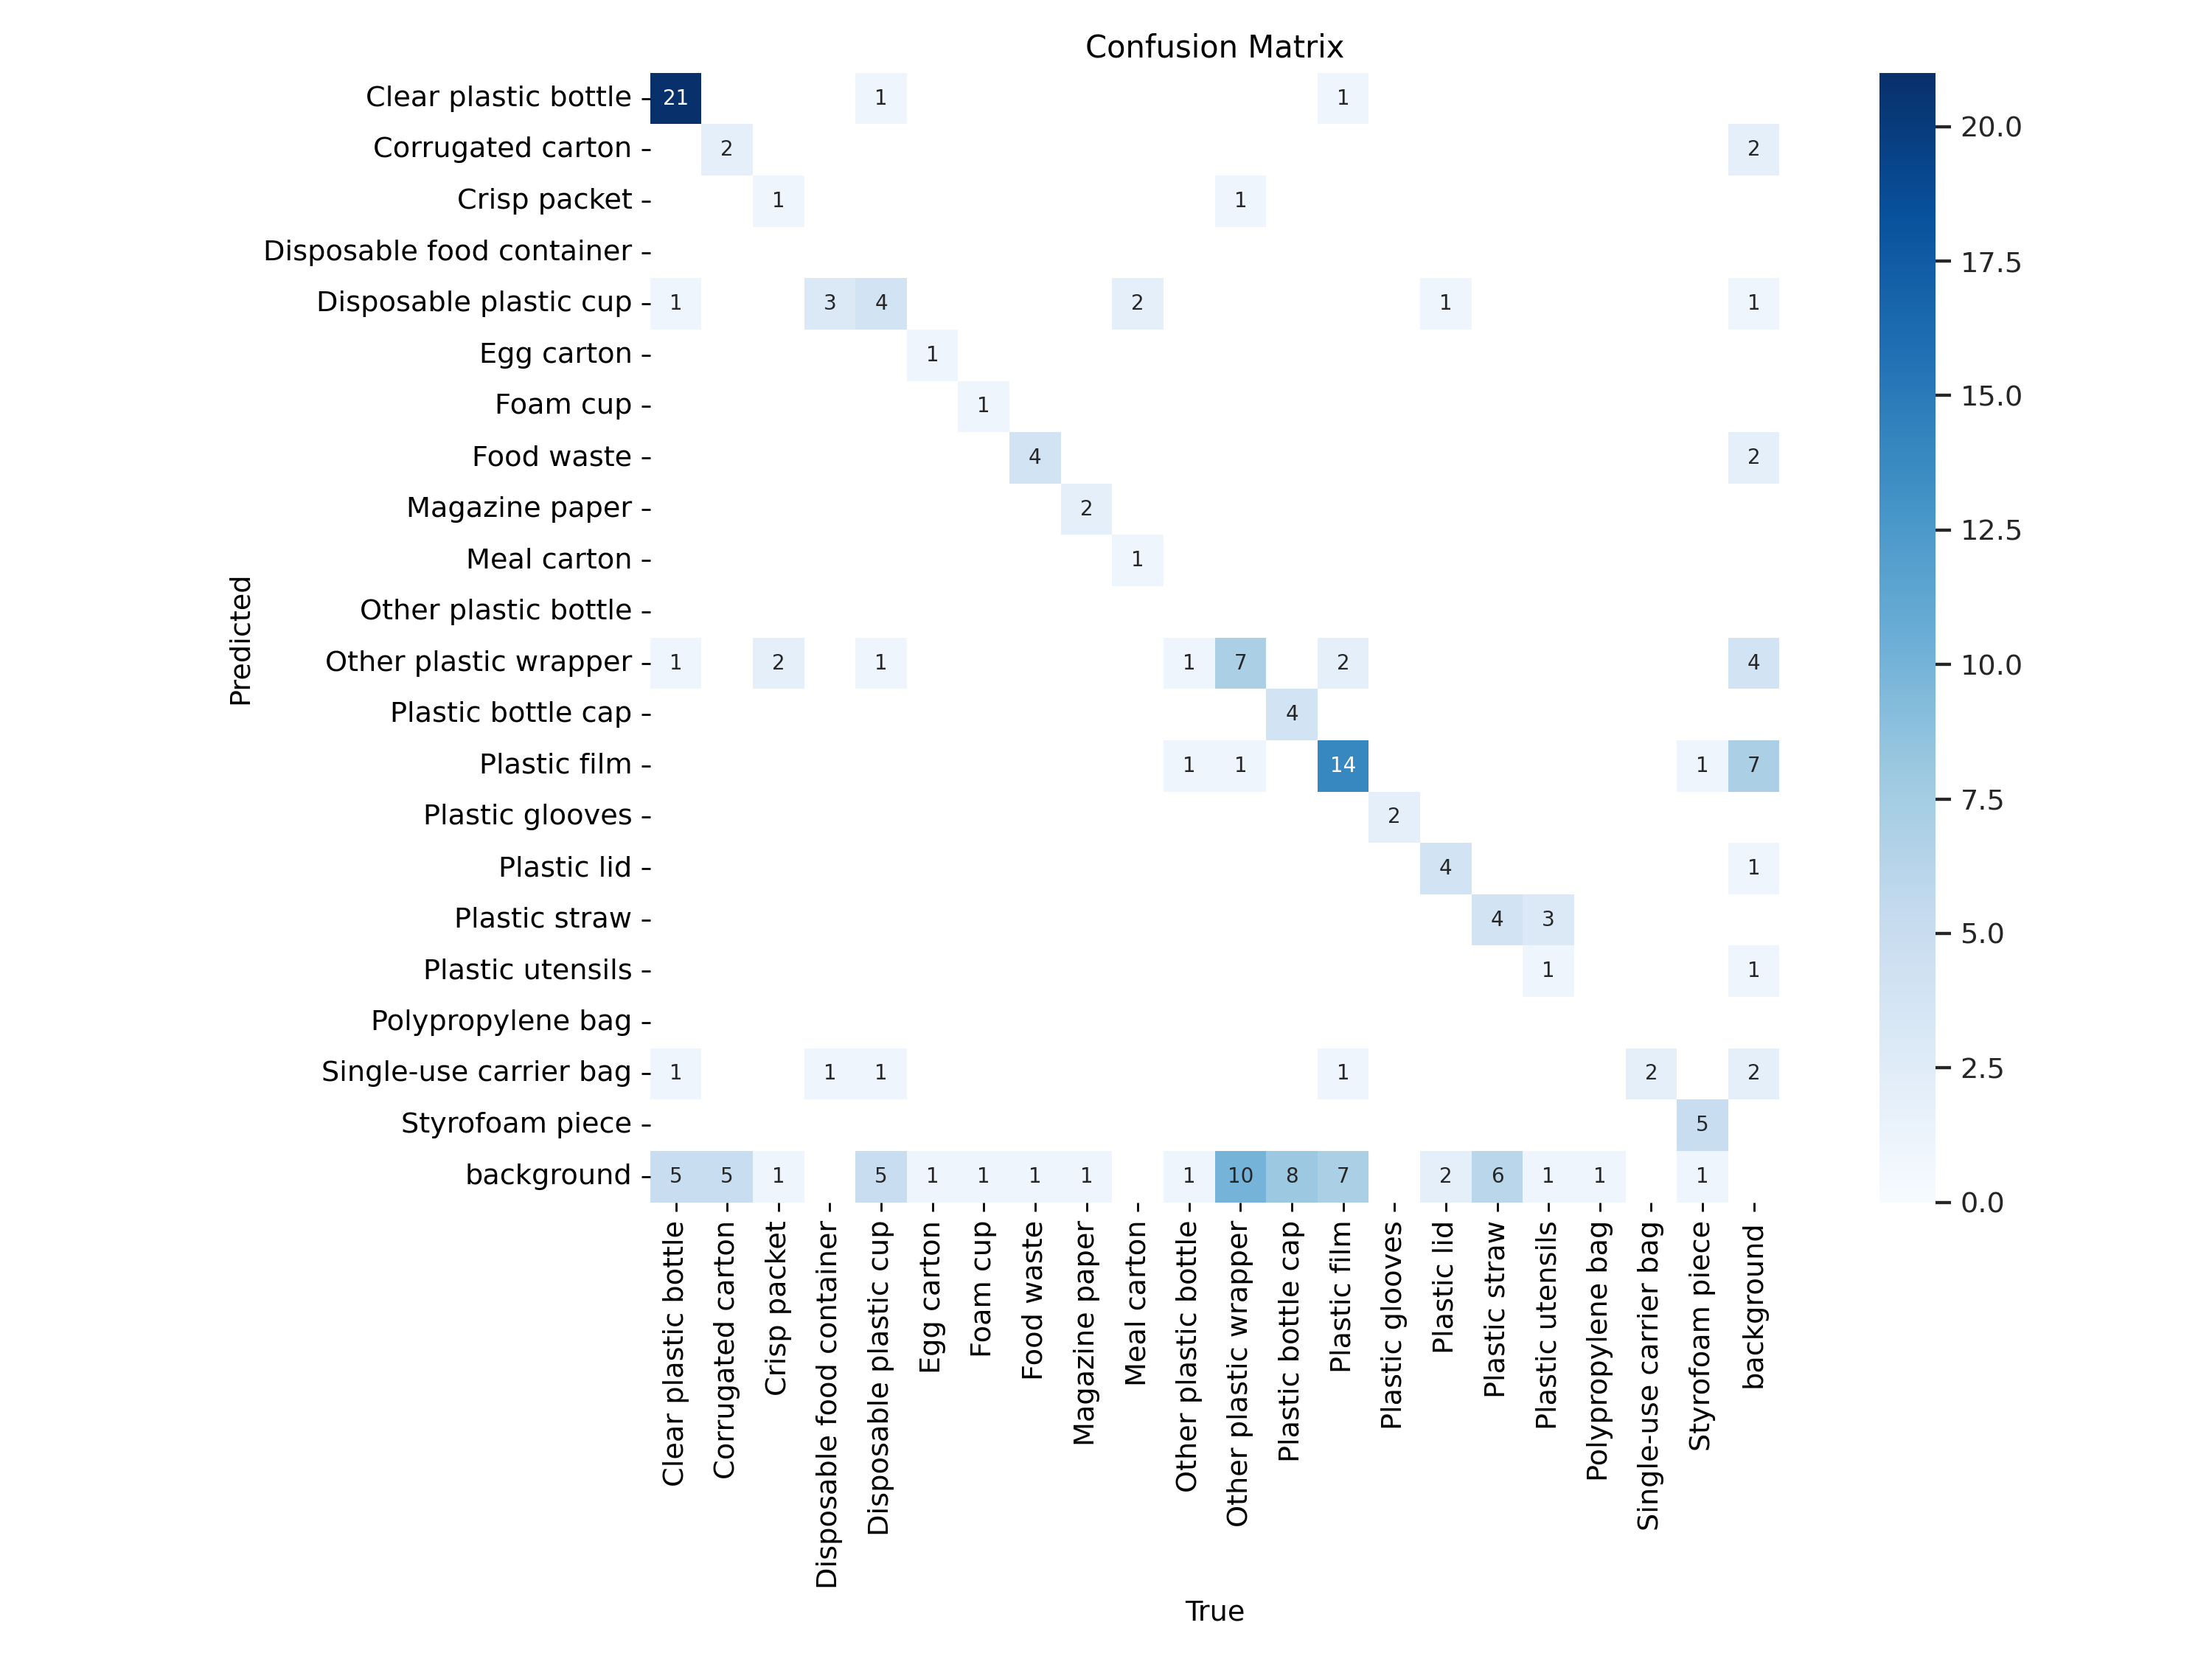

In [10]:
%cd {HOME}
# runs/segment/train/weights/best.pt
Image(filename=f'{HOME}/runs/segment/train14/confusion_matrix.png', width=800)


## Metrics

- The box loss, often referred to as localization loss or regression loss, measures how well the model predicts the bounding box coordinates (x, y, width, height) for each object in the image.
- The segmentation loss measures the difference between the predicted segmentation mask and the ground truth mask for each object.
- The classification loss, often simply called the class loss, measures how well the model classifies the objects within the predicted bounding boxes
- mAP50 (mean Average Precision at 50 IoU threshold) is a metric that combines precision and recall to assess the performance of a classification or object detection algorithm.



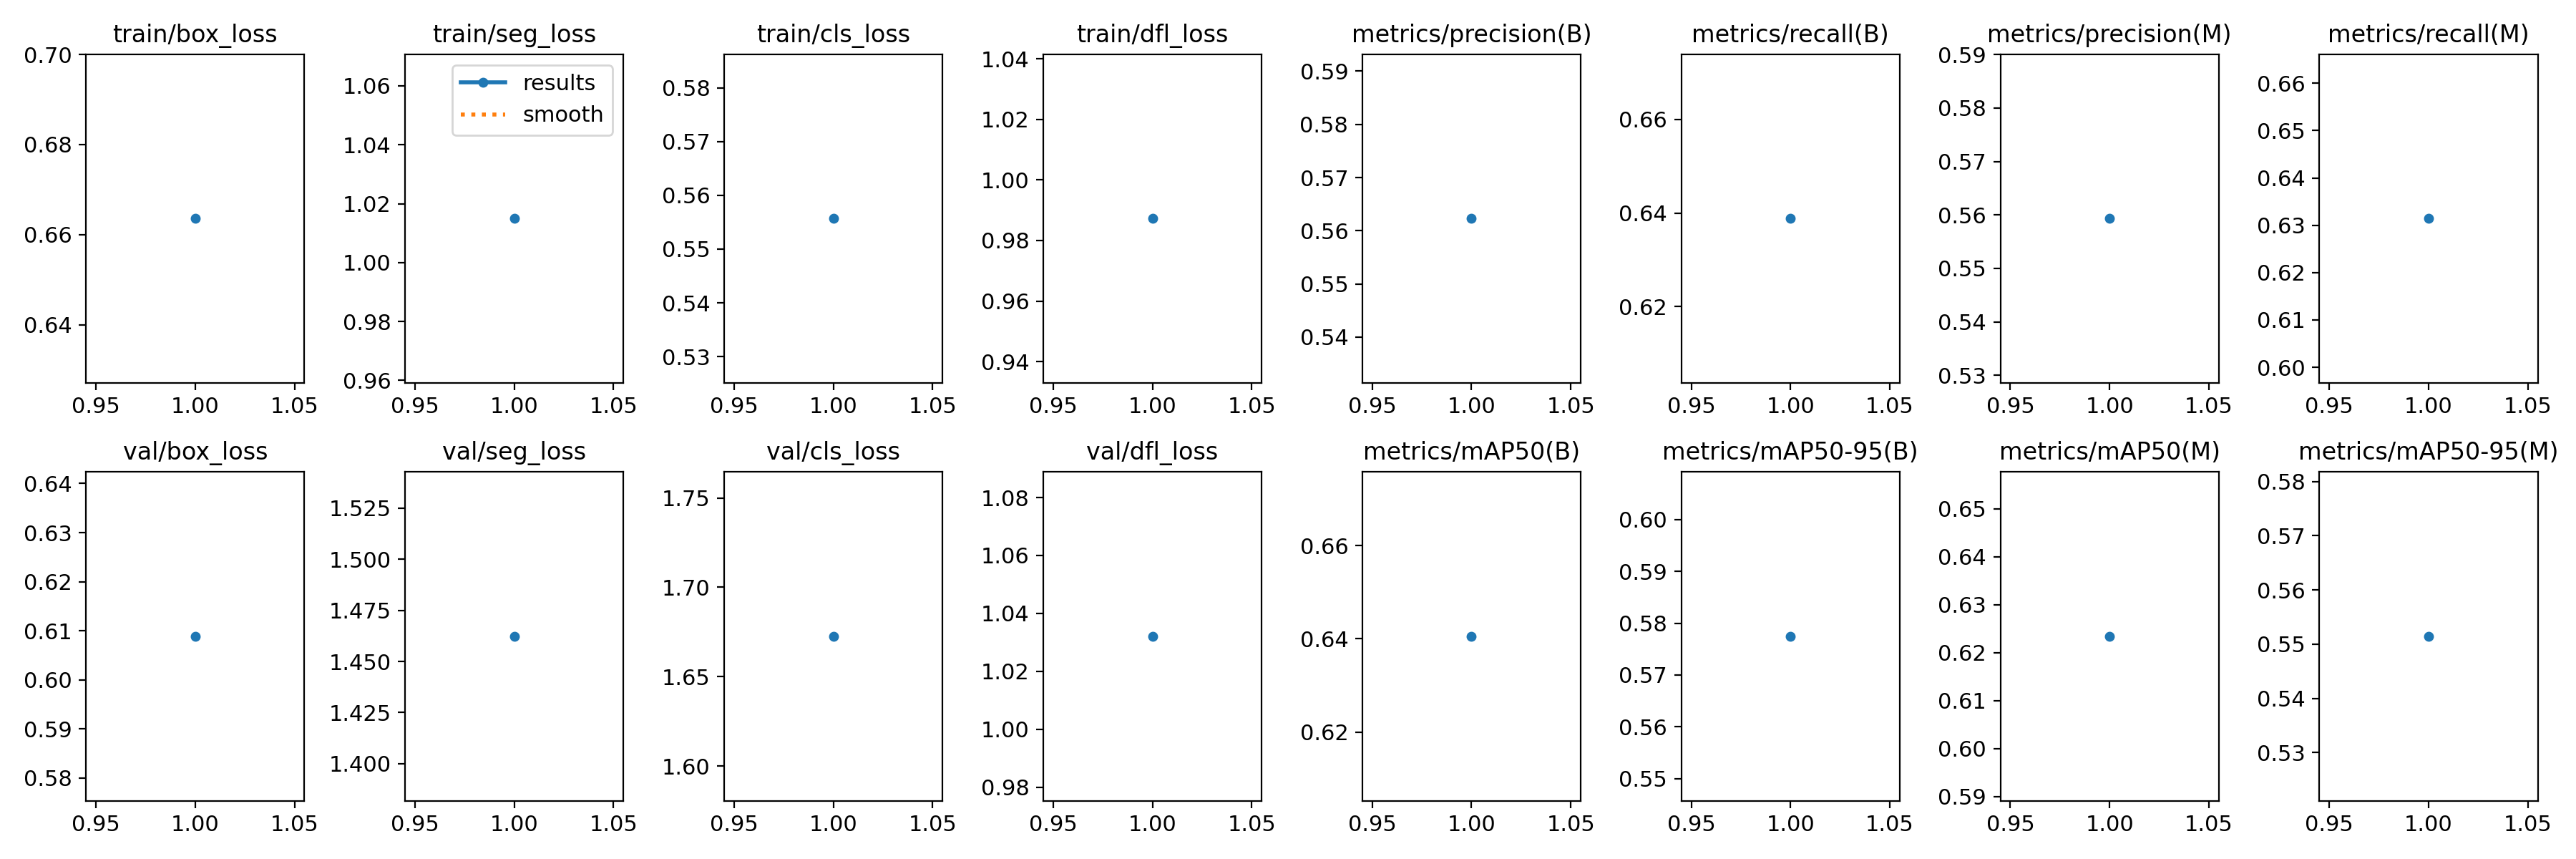

In [11]:
Image(filename=f'{HOME}/runs/segment/train14/results.png', width=1400)

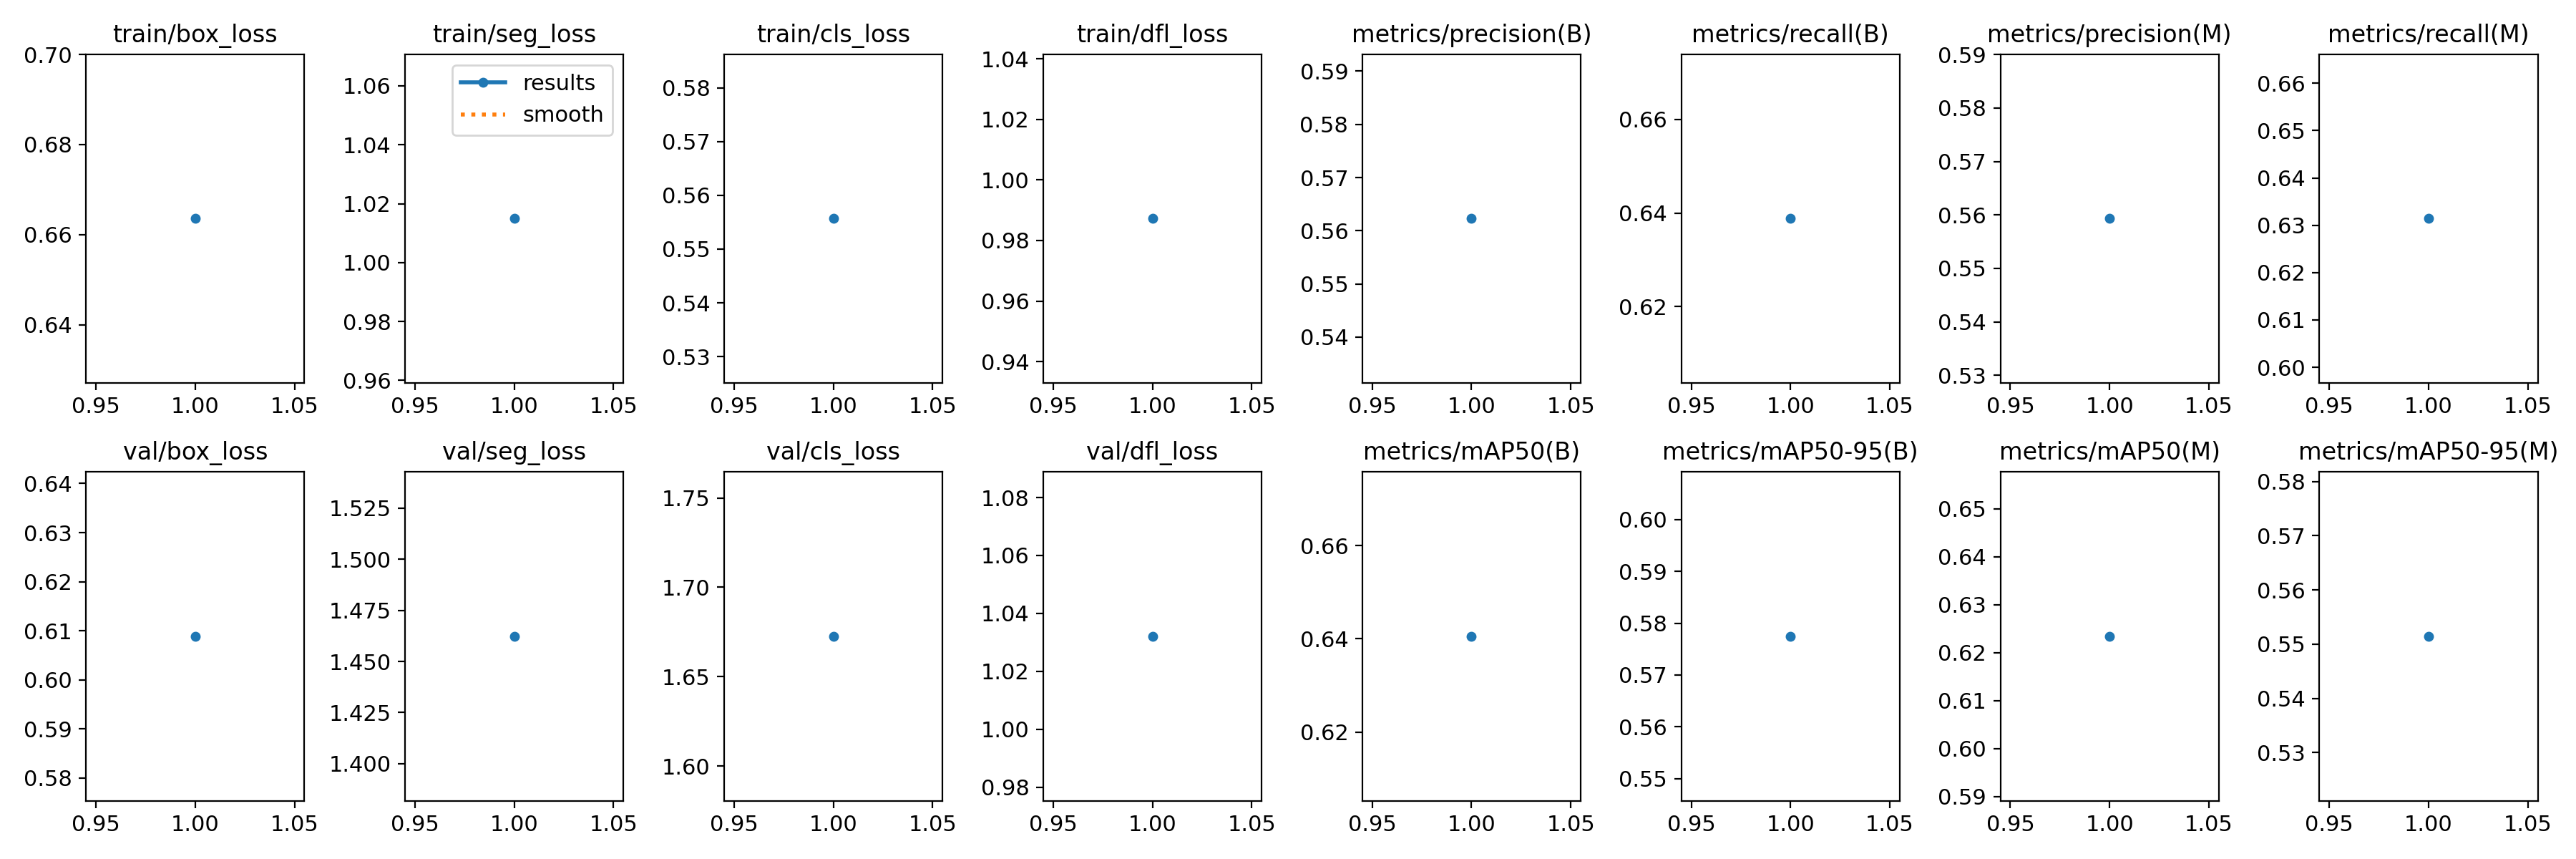

In [12]:
Image(filename=f'{HOME}/runs/segment/train14/results.png', width=1400)

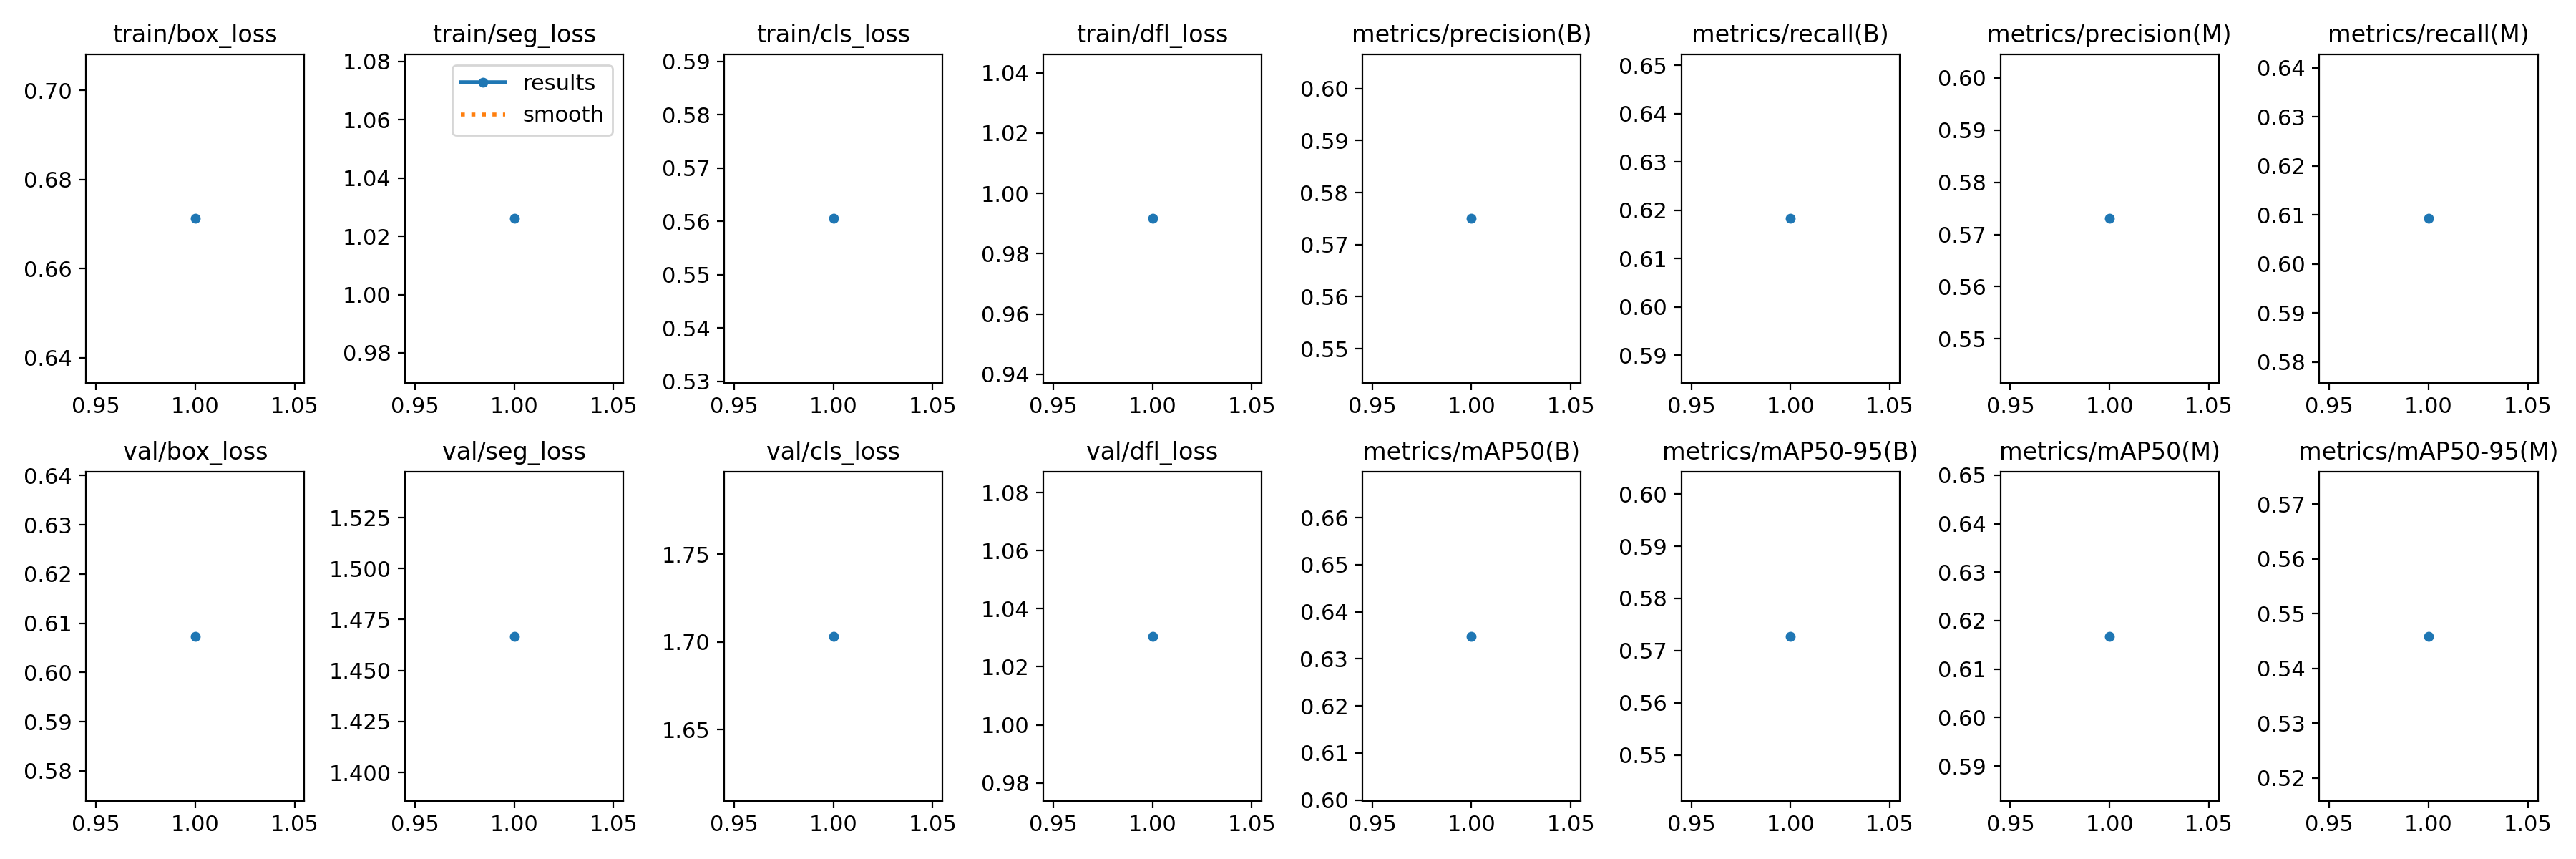

In [14]:
Image(filename=f'{HOME}/runs/segment/train9/results.png', width=1400)

## Other Metrics

In [ ]:
%ls ./datasets/runs/segment/train57

In [ ]:
image_paths

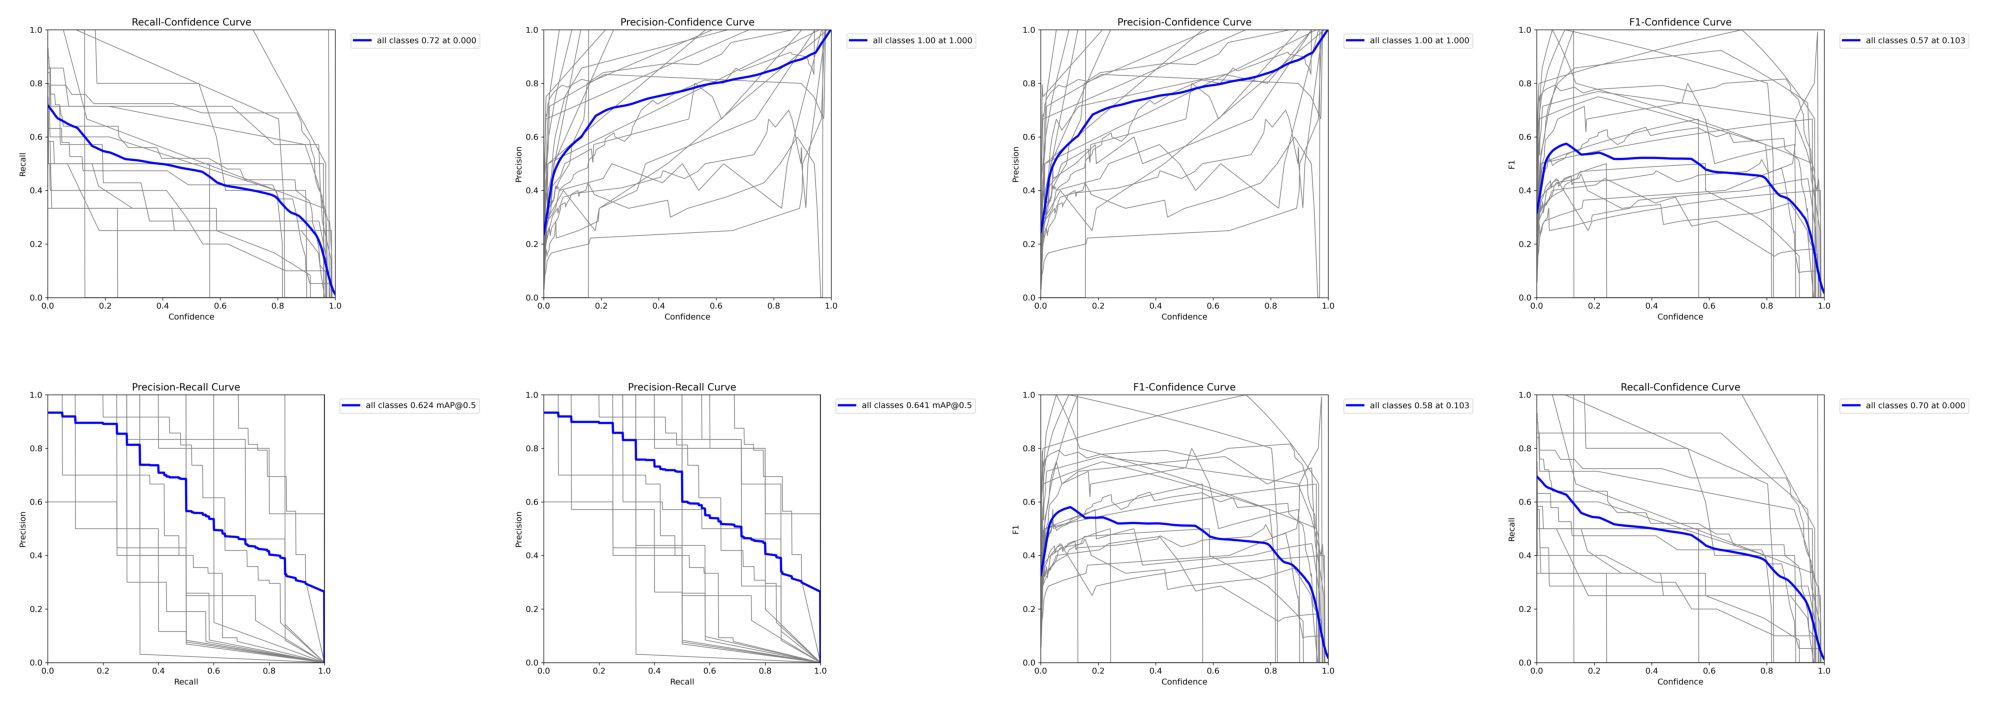

In [13]:
import glob
import matplotlib.pyplot as plt
import os

# Get all image paths
image_paths = glob.glob(f'{HOME}/runs/segment/train14/*curve.png')

# Define number of columns
cols = 4
rows = (len(image_paths) + cols - 1) // cols  # Calculate rows dynamically

# Create figure
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * cols))  # Adjust figure size

# Flatten axes array for easy indexing
axes = axes.flatten()

# Loop through images and display them
for i, image_path in enumerate(image_paths):
    img = plt.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis("off")  # Hide axes

# Hide any unused subplots
for i in range(len(image_paths), len(axes)):
    axes[i].axis("off")

# Show the plot
plt.tight_layout()
plt.show()


## Predictions

In [14]:
for image_path in glob.glob(f'{HOME}/datasets/runs/segment/train14/*pred.jpg'):
    display(Image(filename=image_path, height=600))
    print("\n")

In [131]:
ls {HOME}/datasets/runs/segment/train14/weights/

In [132]:
!cp -r {HOME}/runs/segment/train61322/weights/* {HOME}/datasets/runs/segment/train172/weights

In [15]:
ls {HOME}/runs/segment/train14

args.yaml                                         MaskR_curve.png
BoxF1_curve.png                                   results.csv
BoxP_curve.png                                    results.png
BoxPR_curve.png                                   train_batch0.jpg
BoxR_curve.png                                    train_batch1.jpg
confusion_matrix_normalized.png                   train_batch2.jpg
confusion_matrix.png                              val_batch0_labels.jpg
events.out.tfevents.1743892398.87a570258b6a.40.0  val_batch0_pred.jpg
labels_correlogram.jpg                            val_batch1_labels.jpg
labels.jpg                                        val_batch1_pred.jpg
MaskF1_curve.png                                  val_batch2_labels.jpg
MaskP_curve.png                                   val_batch2_pred.jpg
MaskPR_curve.png                                  weights/


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


In [16]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/segment/train14")

View the status of your deployment at: https://app.roboflow.com/taco-9911u/taco-trash-annotations-in-context-bumvw/15
Share your model with the world at: https://universe.roboflow.com/taco-9911u/taco-trash-annotations-in-context-bumvw/model/15
